In [62]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from operator import add
from copy import deepcopy
from copy import deepcopy
import random
import tensorflow as tf 
from scipy.ndimage import rotate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.python.client import device_lib

In [27]:
import shutil
import random

def move_files(source_dir, dst_dir, num):   
    index_list=[]
    count=0
    for root, dirs, files in os.walk(source_dir):
        while count<=num:
            index=random.randint(0,len(files)-1)
            if index not in index_list:
                index_list.append(index)
                img=cv2.imread(source_dir+"/"+files[index])
                shutil.move(source_dir+"/"+files[index], dst_dir)
                count+=1
            else:
                continue
                

move_files('new_data/images/datagen/train/yes','new_data/images/datagen/test/yes', 30)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [63]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

### LOAD DATA WITH NO AUGMENTATION
---

In [4]:
train_it = datagen.flow_from_directory('new_data/images/datagen/train/',
	class_mode='binary', batch_size=4, target_size=(224, 224))
test_it = datagen.flow_from_directory('new_data/images/datagen/test/',
	class_mode='binary', batch_size=4, target_size=(224, 224))
val_it = datagen.flow_from_directory('new_data/images/datagen/val/',
	class_mode='binary', batch_size=4, shuffle=False, target_size=(224, 224))

Found 484 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


### LOAD DATA WITH AUGMENTATION
---

In [28]:
for path_dir, dirnames, filenames in os.walk("new_data/images/datagen/train/no"):
    for file in filenames:
        pth_img = path_dir + "/" + file
        img = load_img(pth_img)
        data = img_to_array(img)
        samples = np.expand_dims(data, 0)
        datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=[-10,10], height_shift_range=[-10, 10], horizontal_flip=True, vertical_flip=True, rotation_range=180)
        i=0
        for batch in datagen.flow(samples, batch_size=1,save_to_dir='new_data/images/datagen/aug_train/no', save_prefix='no', save_format='jpeg'):
            i += 20
            if i > 20:
                break

for path_dir, dirnames, filenames in os.walk("new_data/images/datagen/train/yes"):
    for file in filenames:
        pth_img = path_dir + "/" + file
        img = load_img(pth_img)
        data = img_to_array(img)
        samples = np.expand_dims(data, 0)
        datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=[-10,10], height_shift_range=[-10, 10], horizontal_flip=True, vertical_flip=True, rotation_range=180)
        i=0
        for batch in datagen.flow(samples, batch_size=1,save_to_dir='new_data/images/datagen/aug_train/yes', save_prefix='yes', save_format='jpeg'):
            i += 20
            if i > 20:
                break

In [64]:
train_it = datagen.flow_from_directory('new_data/images/datagen/aug_train/',
	class_mode='binary', batch_size=4, target_size=(224, 224))
test_it = datagen.flow_from_directory('new_data/images/datagen/test/',
	class_mode='binary', batch_size=4, target_size=(224, 224))
val_it = datagen.flow_from_directory('new_data/images/datagen/val/',
	class_mode='binary', batch_size=4, shuffle=False, target_size=(224, 224))

Found 947 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 62 images belonging to 2 classes.


### CUSTOM CNN MODEL
---

In [65]:
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 224x224 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Dropout(0.2),
# The second convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Dropout(0.2),
# The third convolution
tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Dropout(0.2),
# The fourth convolution
tf.keras.layers.Flatten(),   
#tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
#tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('healthy') and 1 for the other ('metastatic')
tf.keras.layers.Dense(1, activation='sigmoid')])

### PRE-TRAINED RESNET-50 MODEL
---

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
model = tf.keras.models.Sequential()
model.add(ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

### IMPLEMENT EARLY STOPPING 
### SPECIFY FOLDER TO SAVE BEST WEIGHTS BASED ON LOWEST VALIDATION LOSS
---

In [66]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

mc=ModelCheckpoint('./weights', monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_freq='epoch')
cb_list=[es, mc]

### COMPILE MODEL
### LOSS: BINARY CROSS ENTROPY, OPTIMIZER: ADAM
---

In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### LOAD WEIGHTS IF WEIGHTS ARE SAVED IN THE "weights" FOLDER
---

In [59]:
from tensorflow.keras.models import load_model
model_load = load_model('weights')
history_load = model_load.fit(new_train_it, steps_per_epoch=len(new_train_it), validation_data=val_it, validation_steps=len(val_it), epochs=30, callbacks=cb_list)

### OTHERWISE TRAIN FROM SCRATCH 
---

In [68]:
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=30, callbacks=cb_list)

Epoch 1/30
234/237 [============================>.] - ETA: 0s - loss: 1.6166 - accuracy: 0.4684
Epoch 00001: saving model to ./weights
INFO:tensorflow:Assets written to: ./weights\assets
237/237 [==============================] - 5s 22ms/step - loss: 1.6048 - accuracy: 0.4688 - val_loss: 0.6931 - val_accuracy: 0.4839
Epoch 2/30
235/237 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.4995
Epoch 00002: saving model to ./weights
INFO:tensorflow:Assets written to: ./weights\assets
237/237 [==============================] - 5s 21ms/step - loss: 0.6948 - accuracy: 0.4974 - val_loss: 0.6922 - val_accuracy: 0.5161
Epoch 3/30
237/237 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.5269
Epoch 00003: saving model to ./weights
INFO:tensorflow:Assets written to: ./weights\assets
237/237 [==============================] - 5s 21ms/step - loss: 0.6960 - accuracy: 0.5269 - val_loss: 0.6911 - val_accuracy: 0.5161
Epoch 4/30
234/237 [=======================

### PLOT ACCURACY
---

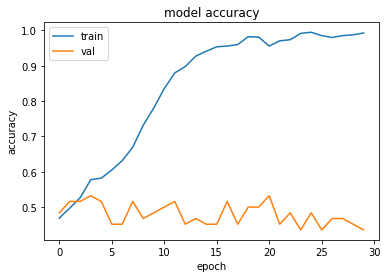

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.legend(['train'], loc='upper left')
plt.show()

### PLOT LOSS
---

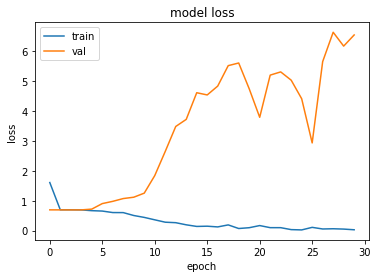

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.legend(['train'], loc='upper left')
plt.show()

### MAKE PREDICTIONS ON TEST SET AND EVALUATE TEST ACCURACY
---

In [72]:
evaluate = model.evaluate(test_it, verbose=1)
pred = model.predict(test_it)
print(model.metrics_names)
print("test loss, test acc:", evaluate)
print(pred)

16/16 [==============================] - 0s 6ms/step - loss: 4.1199 - accuracy: 0.5806
['loss', 'accuracy']
test loss, test acc: [4.119940280914307, 0.5806451439857483]


### PLOT AUC CURVE
---

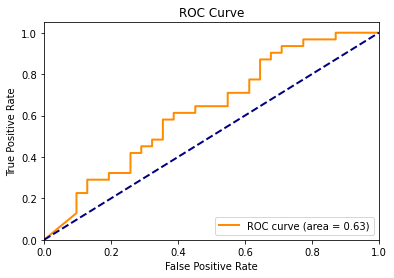

In [73]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_it.labels, pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### OTHER PERFORMANCE METRICS REQUESTED BY DR. AMBER SIMPSON
---

In [ ]:
def ppv(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if tp + fp == 0:
        print("Warning: All predictions negative")
        return 0
    
    return tp / (tp + fp)

 

def npv(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    if tn + fn == 0:
        print("Warning: All predictions positive")
        return 0
    
    return tn / (tn + fn)

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return tn / (tn + fp)

 
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    return tp / (tp + fn)

In [ ]:
ppv = ppv(y_test, pred)
print(ppv)

npv = npv(y_test, pred)
print(npv)

sen = sensitivity(y_test, pred)
print(sen)

spe = specificity(y_test, pred)
print(spe)

### USE GRAD CAM TO UNDERSTAND WHERE THE CNN IS FOCUSING ON IN THE IMAGE
---

In [ ]:
o = 1-(model.layers[-1].output)
model2 = Model(inputs=model.input, outputs=[o])
model2.summary()

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

class GradCAM:
    
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    
    def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs],outputs=[self.model.get_layer(self.layerName).output,self.model.output])
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            print(predictions)
            print(self.classIdx)
            print(predictions[:, self.classIdx])
            loss = predictions[:, self.classIdx]
            print(loss)
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

for i in range(len(X_test)):
    orig = X_test[i]
    image = np.expand_dims(X_test[i], axis=0)
    pred=model.predict(image)
#     if pred<0.5:
#         c=0
#     else:
#         c=1
#     cam = GradCAM(model, 0)
    if pred>0.5:
        cam = GradCAM(model2, 0)
    else:
        cam = GradCAM(model, 0)

    heatmap = cam.compute_heatmap(image)
    print(heatmap.shape)
    print(image.shape)
    heatmap = cv2.resize(heatmap, (217, 217))
    (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
    # draw the predicted label on the output image
    #cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
    # display the original image and resulting heatmap and output image
    # to our screen
    output = np.vstack([orig, heatmap, masks[i]])
    %matplotlib inline
    plt.figure(figsize = (15,15))
    plt.imshow(output)
    plt.show()

### EXTRA FUNCTIONS FOR DR. CHRISTIAN
---

In [ ]:
pred_class = []
for i in range(len(pred)):
    if pred[i][0]<0.5:
        pred_class.append(int(0))
    else:
        pred_class.append(int(1))

In [ ]:
print(len(pred_class))
print(len(val_it.labels))
print(pred_class)
print(val_it.labels)

In [ ]:
pred_diff = []
for i in range(len(pred)):
    if val_it.labels[i]==0:
        pred_diff.append(abs(pred[i][0] - 0))
    else:
        pred_class.append(abs(pred[i][0] - 1))
print(pred_diff)

In [ ]:
correct=0
incorrect=0
for i in range(len(pred_class)):
    if pred_class[i] == val_it.labels[i]:
        correct+=1
    else:
        incorrect+=1
print(correct)
print(incorrect)

In [ ]:
val_it.filenames

In [ ]:
new_train_it = datagen.flow_from_directory('new_data/images/datagen/wrong/',
	class_mode='binary', batch_size=4, target_size=(224, 224))